In [1]:
!pip install -U sentence-transformers

In [2]:
from sentence_transformers import SentenceTransformer, util

# Load once globally
embedding_model = SentenceTransformer("all-MiniLM-L6-v2") 

2025-05-22 23:30:26.767478: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import json
import re
import openai
import os
os.environ["OPENROUTER_API_KEY"] = "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"
import json5
import pandas as pd
import numpy as np
import random
import sys
sys.path.append(os.path.abspath(".."))
import matplotlib.pyplot as plt
import networkx as nx

In [4]:
import importlib
import src.graph_builder
import src.graph_queries
import src.prompt_to_rules
import src.semantic_matcher
importlib.reload(src.graph_queries)
importlib.reload(src.prompt_to_rules)
importlib.reload(src.semantic_matcher)

<module 'src.semantic_matcher' from '/home/sagemaker-user/auto-audience-generator/src/semantic_matcher.py'>

In [5]:
from src.graph_builder import build_knowledge_graph_from_config
from src.graph_queries import apply_persona_to_graph
from src.graph_queries import apply_logical_rule
from src.prompt_to_rules import extract_rules_from_prompt_llm2
from src.prompt_to_rules import extract_rules_from_prompt_llm3
from src.semantic_matcher import SemanticMatcher

In [6]:
# Set seed for reproducibility
np.random.seed(42)

# Generate Users Dataset
user_ids = [f"user_{i}" for i in range(100)]
ages = np.random.randint(18, 70, size=100)
genders = np.random.choice(['Male', 'Female', 'Other'], size=100)
locations = np.random.choice(['California', 'New York', 'Texas', 'Florida', 'Illinois'], size=100)
education_levels = np.random.choice(['High School', 'Bachelor', 'Master', 'PhD', 'College Senior'], size=100)

users_df = pd.DataFrame({
    'user_id': user_ids,
    'age': ages,
    'gender': genders,
    'location': locations,
    'education_level': education_levels
})
users_df.to_csv("../data/users.csv", index=False)

# Generate Products Dataset
product_ids = [f"prod_{i}" for i in range(100)]
categories = np.random.choice(['Electronics', 'Books', 'Fitness', 'Crypto', 'Gaming'], size=100)
tags = np.random.choice(['blockchain', 'sports', 'AI', 'yoga', 'finance'], size=100)

products_df = pd.DataFrame({
    'product_id': product_ids,
    'category': categories,
    'tag': tags
})
products_df.to_csv("../data/products.csv", index=False)

# Generate Orders Dataset
orders = []
for _ in range(200):
    orders.append({
        'user_id': random.choice(user_ids),
        'order_id': f"order_{random.randint(1, 1000)}",
        'product_id': random.choice(product_ids),
        'order_date': pd.Timestamp('2024-01-01') + pd.to_timedelta(random.randint(0, 100), unit='d')
    })
orders_df = pd.DataFrame(orders)
orders_df.to_csv("../data/orders.csv", index=False)

# Generate Streaming Dataset
content_names = [f"content_{i}" for i in range(100)]
genres = np.random.choice(['sports', 'technology', 'crypto', 'fitness', 'news'], size=100)
streaming = []
for _ in range(200):
    streaming.append({
        'user_id': random.choice(user_ids),
        'content_name': random.choice(content_names),
        'timestamp': pd.Timestamp('2024-01-01') + pd.to_timedelta(random.randint(0, 100), unit='d'),
        'genre': random.choice(genres),
        'watch_duration': random.randint(5, 120)
    })
streaming_df = pd.DataFrame(streaming)
streaming_df.to_csv("../data/streaming.csv", index=False)


In [7]:
G = build_knowledge_graph_from_config(
    "../config/graph_schema.json",
    {
        "users": "../data/users.csv",
        "products": "../data/products.csv",
        "orders": "../data/orders.csv",
        "streaming": "../data/streaming.csv"
    }
)

✅ Graph successfully created
Number of nodes: 296
Number of edges: 660


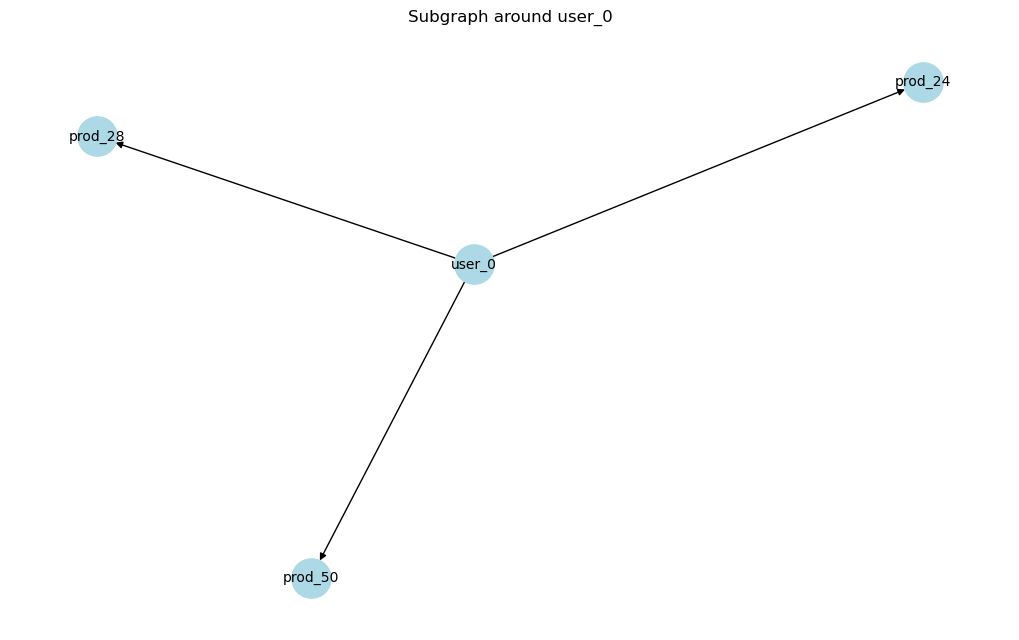

In [8]:
sub_nodes = list(G.successors('user_0')) + ['user_0']
subgraph = G.subgraph(sub_nodes)

plt.figure(figsize=(10, 6))
nx.draw(subgraph, with_labels=True, node_size=800, node_color='lightblue', font_size=10)
plt.title("Subgraph around user_0")
plt.show()

In [9]:
prompt = "Find crypto enthusiasts"
rules = extract_rules_from_prompt_llm2(prompt)
print("Extracted Persona Rule:", rules)

audience = apply_persona_to_graph(G, rules["persona"])
print("Final Audience:", audience)

Extracted Persona Rule: {'persona': {'tag': ['blockchain', 'cryptocurrency'], 'genre': ['technology', 'finance']}}
Final Audience: {'user_50', 'user_74', 'user_94', 'user_37', 'user_4', 'user_11', 'user_20', 'user_12', 'user_29', 'user_23', 'user_59', 'user_36', 'user_55', 'user_28', 'user_47', 'user_9', 'user_90', 'user_82', 'user_65', 'user_42', 'user_96', 'user_87', 'user_89', 'user_34'}


In [10]:
prompt = "Find users interested in investing"
rules = extract_rules_from_prompt_llm2(prompt)
print("Extracted Persona Rule:", rules)

audience = apply_persona_to_graph(G, rules["persona"])
print("Final Audience:", audience)

Extracted Persona Rule: {'persona': {'age': {'operator': '>=', 'value': 18}, 'tag': ['investing', 'finance'], 'genre': ['business', 'finance']}}
Final Audience: {'user_50', 'user_91', 'user_74', 'user_57', 'user_51', 'user_94', 'user_37', 'user_13', 'user_35', 'user_84', 'user_10', 'user_52', 'user_29', 'user_60', 'user_81', 'user_23', 'user_88', 'user_59', 'user_72', 'user_36', 'user_28', 'user_56', 'user_48', 'user_86', 'user_82', 'user_41', 'user_42', 'user_96', 'user_58', 'user_87', 'user_80', 'user_34'}


In [11]:
prompt = "Find users interested in education"
rules = extract_rules_from_prompt_llm2(prompt)
print("Extracted Persona Rule:", rules)

audience = apply_persona_to_graph(G, rules["persona"])
print("Final Audience:", audience)

Extracted Persona Rule: {'persona': {'education_level': 'High School', 'tag': ['education'], 'genre': ['education']}}
Final Audience: set()


In [12]:
prompt = "Find users about to graduate"
rules = extract_rules_from_prompt_llm2(prompt)
print("Extracted Persona Rule:", rules)

audience = apply_persona_to_graph(G, rules["persona"])
print("Final Audience:", audience)

Extracted Persona Rule: {'persona': {'age': {'operator': '>=', 'value': 21}, 'education_level': 'College Senior', 'tag': ['job prep', 'career'], 'genre': ['technology']}}
Final Audience: {'user_18', 'user_74', 'user_91', 'user_40', 'user_85', 'user_37', 'user_13', 'user_4', 'user_35', 'user_11', 'user_84', 'user_20', 'user_12', 'user_52', 'user_19', 'user_71', 'user_60', 'user_32', 'user_8', 'user_23', 'user_76', 'user_59', 'user_72', 'user_46', 'user_36', 'user_55', 'user_28', 'user_77', 'user_70', 'user_56', 'user_22', 'user_47', 'user_9', 'user_33', 'user_31', 'user_2', 'user_54', 'user_48', 'user_16', 'user_86', 'user_92', 'user_90', 'user_25', 'user_65', 'user_17', 'user_42', 'user_87', 'user_80', 'user_89', 'user_78'}


In [13]:
matcher = SemanticMatcher(G)

In [14]:
expanded = matcher.expand("finance", verbose=True )
print("Expanded:", expanded)

expanded = matcher.expand("crypto", verbose=True )
print("Expanded:", expanded)


🔍 Semantic matches for: 'finance' (threshold=0.4)
→ finance (score: 1.000)
→ blockchain (score: 0.447)
→ crypto (score: 0.412)
→ technology (score: 0.402)
Expanded: ['finance', 'blockchain', 'crypto', 'technology']

🔍 Semantic matches for: 'crypto' (threshold=0.4)
→ crypto (score: 1.000)
→ blockchain (score: 0.576)
→ finance (score: 0.412)
Expanded: ['crypto', 'blockchain', 'finance']


In [15]:
query = "crypto"
query_embedding = matcher.model.encode(query, convert_to_tensor=True)
scores = util.cos_sim(query_embedding, matcher.kg_embeddings)[0]

scored_terms = list(zip(matcher.kg_terms, scores.tolist()))
scored_terms.sort(key=lambda x: x[1], reverse=True)

for term, score in scored_terms[:10]:
    print(f"{term:20s} → score: {score:.3f}")

crypto               → score: 1.000
blockchain           → score: 0.576
finance              → score: 0.412
technology           → score: 0.336
ai                   → score: 0.300
news                 → score: 0.249
sports               → score: 0.240
fitness              → score: 0.186
yoga                 → score: 0.174


In [16]:
rules_obj = extract_rules_from_prompt_llm3("Find crypto enthusiasts")

print("Extracted Rules:", rules_obj)

for rule in rules_obj.get("rules", []):
    print(f"\n🔍 Audience: {rule['name']}")
    audience = apply_logical_rule(G, rule, matcher=matcher)
    print(f"🎯 Users: {audience}")

Extracted Rules: {'rules': [{'name': 'Crypto Enthusiasts', 'conditions': {'or': [{'field': 'tag', 'in': ['crypto']}, {'field': 'genre', 'in': ['crypto', 'blockchain']}]}}]}

🔍 Audience: Crypto Enthusiasts
🎯 Users: {'user_91', 'user_83', 'user_85', 'user_57', 'user_51', 'user_35', 'user_11', 'user_20', 'user_79', 'user_32', 'user_88', 'user_76', 'user_59', 'user_61', 'user_44', 'user_47', 'user_54', 'user_7', 'user_82', 'user_41', 'user_42', 'user_96', 'user_34', 'user_18', 'user_64', 'user_75', 'user_94', 'user_12', 'user_52', 'user_19', 'user_71', 'user_29', 'user_21', 'user_28', 'user_95', 'user_31', 'user_2', 'user_14', 'user_92', 'user_87', 'user_78', 'user_50', 'user_63', 'user_74', 'user_37', 'user_84', 'user_60', 'user_81', 'user_8', 'user_43', 'user_72', 'user_46', 'user_36', 'user_97', 'user_1', 'user_56', 'user_22', 'user_48', 'user_16', 'user_86', 'user_24', 'user_27', 'user_90', 'user_65', 'user_17', 'user_73', 'user_38', 'user_66', 'user_40', 'user_13', 'user_4', 'user_10'

In [17]:
rules_obj = extract_rules_from_prompt_llm3("Find crypto enthusiasts")

print("Extracted Rules:", rules_obj)

for rule in rules_obj.get("rules", []):
    print(f"\n🔍 Audience: {rule['name']}")
    audience = apply_logical_rule(G, rule, matcher=matcher)
    print(f"🎯 Users: {audience}")

Extracted Rules: {'rules': [{'name': 'Crypto Enthusiasts', 'conditions': {'or': [{'field': 'tag', 'in': ['crypto']}, {'field': 'genre', 'in': ['finance', 'tech', 'cryptocurrency']}]}}]}

🔍 Audience: Crypto Enthusiasts
🎯 Users: {'user_91', 'user_83', 'user_85', 'user_57', 'user_51', 'user_35', 'user_11', 'user_20', 'user_79', 'user_32', 'user_88', 'user_76', 'user_59', 'user_61', 'user_44', 'user_47', 'user_99', 'user_54', 'user_30', 'user_7', 'user_82', 'user_41', 'user_42', 'user_96', 'user_34', 'user_18', 'user_64', 'user_75', 'user_94', 'user_12', 'user_52', 'user_19', 'user_71', 'user_29', 'user_21', 'user_28', 'user_95', 'user_31', 'user_2', 'user_93', 'user_14', 'user_92', 'user_39', 'user_87', 'user_78', 'user_50', 'user_49', 'user_63', 'user_6', 'user_74', 'user_37', 'user_84', 'user_62', 'user_60', 'user_81', 'user_8', 'user_43', 'user_72', 'user_46', 'user_36', 'user_97', 'user_1', 'user_56', 'user_22', 'user_48', 'user_16', 'user_86', 'user_24', 'user_27', 'user_90', 'user_6

In [18]:
rules_obj = extract_rules_from_prompt_llm3("Find crypto enthusiasts")

print("Extracted Rules:", rules_obj)

for rule in rules_obj.get("rules", []):
    print(f"\n🔍 Audience: {rule['name']}")
    audience = apply_logical_rule(G, rule, matcher=matcher)
    print(f"🎯 Users: {audience}")

Extracted Rules: {'rules': [{'name': 'Crypto Enthusiasts', 'conditions': {'or': [{'field': 'tag', 'in': ['crypto']}, {'field': 'genre', 'in': ['finance', 'tech', 'cryptocurrency']}]}}]}

🔍 Audience: Crypto Enthusiasts
🎯 Users: {'user_91', 'user_83', 'user_85', 'user_57', 'user_51', 'user_35', 'user_11', 'user_20', 'user_79', 'user_32', 'user_88', 'user_76', 'user_59', 'user_61', 'user_44', 'user_47', 'user_99', 'user_54', 'user_30', 'user_7', 'user_82', 'user_41', 'user_42', 'user_96', 'user_34', 'user_18', 'user_64', 'user_75', 'user_94', 'user_12', 'user_52', 'user_19', 'user_71', 'user_29', 'user_21', 'user_28', 'user_95', 'user_31', 'user_2', 'user_93', 'user_14', 'user_92', 'user_39', 'user_87', 'user_78', 'user_50', 'user_49', 'user_63', 'user_6', 'user_74', 'user_37', 'user_84', 'user_62', 'user_60', 'user_81', 'user_8', 'user_43', 'user_72', 'user_46', 'user_36', 'user_97', 'user_1', 'user_56', 'user_22', 'user_48', 'user_16', 'user_86', 'user_24', 'user_27', 'user_90', 'user_6

In [19]:
rules_obj = extract_rules_from_prompt_llm3("Find users interested in investing")

print("Extracted Rules:", rules_obj)

for rule in rules_obj.get("rules", []):
    print(f"\n🔍 Audience: {rule['name']}")
    audience = apply_logical_rule(G, rule, matcher=matcher)
    print(f"🎯 Users: {audience}")

Extracted Rules: {'rules': [{'name': 'Investors by tags', 'conditions': {'and': [{'or': [{'field': 'tag', 'in': ['investment', 'stocks', 'real_estate']}, {'field': 'genre', 'in': ['finance', 'business']}]}]}}, {'name': 'Young investors by location', 'conditions': {'and': [{'field': 'age', 'operator': '>', 'value': 18}, {'field': 'location', 'in': ['New York', 'California']}, {'or': [{'field': 'tag', 'in': ['investment', 'stocks']}, {'field': 'genre', 'in': ['finance']}]}]}}, {'name': 'Gender-specific investors', 'conditions': {'and': [{'field': 'gender', 'equal_to': 'female'}, {'or': [{'field': 'tag', 'in': ['investment', 'retirement']}, {'field': 'genre', 'in': ['finance', 'economy']}]}]}}]}

🔍 Audience: Investors by tags
🎯 Users: {'user_91', 'user_83', 'user_85', 'user_57', 'user_51', 'user_35', 'user_11', 'user_20', 'user_79', 'user_32', 'user_88', 'user_76', 'user_59', 'user_61', 'user_44', 'user_47', 'user_99', 'user_54', 'user_30', 'user_7', 'user_82', 'user_41', 'user_42', 'user

In [20]:
rules_obj = extract_rules_from_prompt_llm3("Find users who are about to retire")

print("Extracted Rules:", rules_obj)

for rule in rules_obj.get("rules", []):
    print(f"\n🔍 Audience: {rule['name']}")
    audience = apply_logical_rule(G, rule, matcher=matcher)
    print(f"🎯 Users: {audience}")

Extracted Rules: {'rules': [{'name': 'Users nearing retirement', 'conditions': {'and': [{'field': 'age', 'operator': '>=', 'value': 55}, {'field': 'age', 'operator': '<', 'value': 70}]}}]}

🔍 Audience: Users nearing retirement
🎯 Users: set()


In [22]:
rules_obj = extract_rules_from_prompt_llm3("Find users who are about to retire. Don't limit only on age as criteria")

print("Extracted Rules:", rules_obj)

for rule in rules_obj.get("rules", []):
    print(f"\n🔍 Audience: {rule['name']}")
    audience = apply_logical_rule(G, rule, matcher=matcher)
    print(f"🎯 Users: {audience}")

Extracted Rules: {'rules': [{'name': 'Pre-retirement users', 'conditions': {'and': [{'field': 'age', 'operator': '>=', 'value': 55}, {'field': 'age', 'operator': '<', 'value': 70}, {'or': [{'field': 'tag', 'in': ['retirement', 'pension']}, {'field': 'genre', 'in': ['finance', 'investment']}]}]}}]}

🔍 Audience: Pre-retirement users
🎯 Users: set()
